In [1]:
# indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_high_unique/clonal_shifts/variants_init/donors/donor0/clones/knn_kparam_30/"
# outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_high_unique/single_clones/donor0/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_clones/clones_ranked/"
# cells_meta_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_high_unique/single_clones/donor0/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_clones/cells_meta.tsv"

# is_mt = False
# condition = "inputOnly"


indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_standard_constraints_None/clonal_shifts/variants_simpleUnion/donors/donor0/clones/knn_kparam_30"
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_standard_constraints_None/single_clones/donor0/cloneMethod_variants_simpleUnion_knn_resolution_30/clonalShift_method_clones/clones_ranked"
cells_meta_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_standard_constraints_None/single_clones/donor0/cloneMethod_variants_simpleUnion_knn_resolution_30/clonalShift_method_clones/cells_meta.tsv"
is_mt = False 
condition = "None"
clone_id = "cloneID" # "den_clust"
p_thresh = 0.1 


#indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_high_pct/clonal_shifts/variants_init/donors/donor3/clones/knn_kparam_30"
#outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_high_pct/repr_clones/donor3/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_clones/clones_ranked"
#condition = None
#is_mt = False

cells_meta_f = "" #"/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_high_pct/repr_clones/donor3/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_clones/cells_meta.tsv"


In [2]:
%load_ext autoreload
%autoreload 2
from glob import glob
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import seaborn as sns
import matplotlib.pyplot as plt

from src import clonal_shifts as cs
from icecream import ic

from mplh import cluster_help as ch

from scipy.stats import rankdata, gmean


fig_utils from mplh


## Load ncells and save to output. Sort by ncells

In [3]:
pd.read_csv(join(indir, "input_ncells.csv"), index_col=0)

,Unnamed: 0.1,clusterID,cloneID,count,log2_count
0,0,0,0_0,34,5.129283
1,1,0,0_11,2,1.584963
2,2,0,0_15,1,1.000000
3,3,0,0_19,1,1.000000
4,4,0,0_20,1,1.000000
...,...,...,...,...,...
104,104,10,0_8,1,1.000000
105,105,10,0_9,1,1.000000
106,106,11,0_30,1,1.000000
107,107,11,0_6,1,1.000000


In [4]:
noInput_ncells = pd.read_csv(join(indir, "noInput_ncells.csv"),  index_col=0)
input_ncells = pd.read_csv(join(indir, "input_ncells.csv"), index_col=0)

def get_clone_ncells(df):
    if df.shape[0] == 0:
        df = pd.DataFrame(columns=["count"])
        df.index.name = clone_id
        return df
    return df.groupby(clone_id).sum()[["count"]].sort_values(by="count")[::-1]


input_ncells = get_clone_ncells(input_ncells)#.groupby(clone_id).sum()[["count"]].sort_values(by="count")[::-1]
noInput_ncells = get_clone_ncells(noInput_ncells) #.groupby(clone_id).sum()[["count"]].sort_values(by="count")[::-1]
ncells_df = pd.merge(input_ncells,noInput_ncells,left_index=True, right_index=True, suffixes=["_input", "_cultured"],
                    how="outer").fillna(0)
ncells_df = ncells_df.loc[ncells_df.sum(axis=1).sort_values()[::-1].index]
ncells_df

,count_input,count_cultured
cloneID,,
0_0,157,0
0_4,38,0
0_5,32,0
0_6,26,0
0_8,13,0
0_11,8,0
0_10,6,0
0_12,6,0
0_21,6,0


## Norm ncells for each and get ratio

In [5]:
norm_ncells_df = ncells_df/ncells_df.sum(axis=0)
norm_ncells_df

norm_ncells_df["fold"] = norm_ncells_df["count_cultured"]/norm_ncells_df["count_input"].fillna(0)
norm_ncells_df

,count_input,count_cultured,fold
cloneID,,,
0_0,0.451149,NaN,NaN
0_4,0.109195,NaN,NaN
0_5,0.091954,NaN,NaN
0_6,0.074713,NaN,NaN
0_8,0.037356,NaN,NaN
0_11,0.022989,NaN,NaN
0_10,0.017241,NaN,NaN
0_12,0.017241,NaN,NaN
0_21,0.017241,NaN,NaN


## Load shuffle hypergeometric results for input and cultured
## Convert into long df with cloneID ('index'), clusterID ('variable'), pval, method (hypergeo or one of four shuffle methods), and condition ('input' or 'cultured')

In [6]:
noInput_hyper = pd.read_csv(join(indir, "noInput_hypergeo_pvals.csv"),  index_col=0)
noInput_shuffle_df = pd.read_csv(join(indir, "noInput_shuffle_results_pvals.csv"), index_col=0)
noInput_shuffle_df = noInput_shuffle_df.rename({"value":"pval"}, axis=1)

input_hyper = pd.read_csv(join(indir, "input_hypergeo_pvals.csv"), index_col=0)
input_shuffle_df = pd.read_csv(join(indir, "input_shuffle_results_pvals.csv"), index_col=0)

input_shuffle_df = input_shuffle_df.rename({"value":"pval"}, axis=1)
input_shuffle_df

input_hyper_df = input_hyper.reset_index().melt(id_vars="index", value_name="pval")
input_hyper_df["method"] = "hypergeo"
noInput_hyper_df = noInput_hyper.reset_index().melt(id_vars="index", value_name="pval")
noInput_hyper_df["method"] = "hypergeo"


noInput_hyper_df["condition"] = "cultured"
noInput_shuffle_df["condition"] = "cultured"
input_hyper_df["condition"] = "input"
input_shuffle_df["condition"] = "input"


In [7]:
input_df = pd.concat((input_hyper_df, input_shuffle_df), axis=0, ignore_index=True)
input_df["variable"] = input_df["variable"].astype(object).astype(str)

noInput_df = pd.concat((noInput_hyper_df, noInput_shuffle_df), axis=0, ignore_index=True)
noInput_df["variable"] = noInput_df["variable"].astype(object).astype(str)


df = pd.concat((input_df, noInput_df), axis=0).reset_index(drop=True)
#df = pd.merge(input_df, noInput_df, on=["index", "variable", "method"], suffixes=["_input", "_cultured"])
df

,index,variable,pval,method,condition
0,0_0,0,0.262534,hypergeo,input
1,0_10,0,0.748131,hypergeo,input
2,0_11,0,0.324229,hypergeo,input
3,0_12,0,0.748131,hypergeo,input
4,0_14,0,0.620043,hypergeo,input
...,...,...,...,...,...
1495,0_4,12,1.000000,clone_min,input
1496,0_5,12,1.000000,clone_min,input
1497,0_6,12,1.000000,clone_min,input
1498,0_8,12,1.000000,clone_min,input


## Create 'sig score' that merges the hypergeo and the shuffle results. Score 0-4, with 4 the highest

In [8]:
p_df_group, p_df_out = cs.hypergeo_score(df, p_thresh )
p_df_group

(1500, 6)
False
name ('0_0', '0', 'input')
name ('0_0', '1', 'input')
name ('0_0', '10', 'input')
name ('0_0', '11', 'input')
name ('0_0', '12', 'input')
name ('0_0', '2', 'input')
name ('0_0', '3', 'input')
name ('0_0', '4', 'input')
name ('0_0', '5', 'input')
name ('0_0', '6', 'input')
name ('0_0', '7', 'input')
name ('0_0', '8', 'input')
name ('0_10', '0', 'input')
name ('0_10', '1', 'input')
name ('0_10', '10', 'input')
name ('0_10', '11', 'input')
name ('0_10', '12', 'input')
name ('0_10', '2', 'input')
name ('0_10', '3', 'input')
name ('0_10', '4', 'input')
name ('0_10', '5', 'input')
name ('0_10', '6', 'input')
name ('0_10', '7', 'input')
name ('0_10', '8', 'input')
name ('0_11', '0', 'input')
name ('0_11', '1', 'input')
name ('0_11', '10', 'input')
name ('0_11', '11', 'input')
name ('0_11', '12', 'input')
name ('0_11', '2', 'input')
name ('0_11', '3', 'input')
name ('0_11', '4', 'input')
name ('0_11', '5', 'input')
name ('0_11', '6', 'input')
name ('0_11', '7', 'input')
name ('

index  variable  condition
0_0    0         input        0
       1         input        0
       10        input        0
       11        input        0
       12        input        4
                             ..
0_9    4         input        0
       5         input        0
       6         input        0
       7         input        1
       8         input        0
Length: 300, dtype: int64

In [9]:
p_df_out

cluster_condition,0_input,10_input,11_input,12_input,1_input,2_input,3_input,4_input,5_input,6_input,7_input,8_input
index,,,,,,,,,,,,
0_0,0,0,0,4,0,0,0,1,0,0,4,0
0_10,0,0,0,1,0,0,0,0,0,1,1,1
0_11,0,0,0,1,0,0,0,0,0,0,1,0
0_12,0,0,0,1,0,0,0,0,0,0,1,0
0_14,0,0,1,1,1,0,0,0,0,0,1,0
0_15,0,0,0,1,0,0,0,0,0,0,1,0
0_18,0,0,0,1,0,1,0,0,0,0,1,0
0_19,0,0,1,1,0,0,0,0,0,0,1,0
0_20,0,0,0,1,0,0,1,0,0,0,1,0


In [10]:
p_df_out.sum()

cluster_condition
0_input      0
10_input     2
11_input    13
12_input    24
1_input      8
2_input      3
3_input      1
4_input      2
5_input      3
6_input      1
7_input     24
8_input      2
dtype: int64

In [11]:
# #p_df_out = p_df_group.reset_index().rename({0:"significant_score", "index":"clone", "variable":"cluster"}, axis=1)
# p_df_out = p_df_group.reset_index().rename({0:"significant_score" }, axis=1)

# p_df_out

# p_df_out["cluster_condition"] = p_df_out.apply(lambda x: f'{x["variable"]}_{x["condition"]}', axis=1)
# p_df_out.sort_values(["index", "cluster_condition"])

# p_df_out = p_df_out.pivot(index='index', columns='cluster_condition', values="significant_score").fillna(0)

# p_df_out

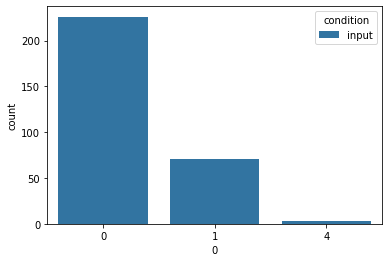

In [12]:
sns.countplot(data=p_df_group.reset_index(), x=0, hue="condition")
plt.savefig(join(outdir, "hypergeo_sig_score_distribution.pdf"))


## Save heatmap for initial hypergeo 

In [13]:
clone_meta = pd.DataFrame(index=p_df_out.columns, columns = ["condition"])
clone_meta["condition"] = ["input" if "input" in x else "cultured" for x in clone_meta.index]
clone_meta

,condition
cluster_condition,
0_input,input
10_input,input
11_input,input
12_input,input
1_input,input
2_input,input
3_input,input
4_input,input
5_input,input


## Input and culture in same heatmap- show clones that were significant in i'th Input cluster label and j'th culture cluster label

a_sig    name Input    sig
0   0_0     0  False
1  0_10     0  False
2  0_11     0  False
3  0_12     0  False
4  0_14     0  False
(0, 0)
b_sig Empty DataFrame
Columns: [name, Cultured, sig]
Index: []
merge_df Empty DataFrame
Columns: []
Index: [0, 1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8]
count Empty DataFrame
Columns: []
Index: [0, 1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8]
No clones significant


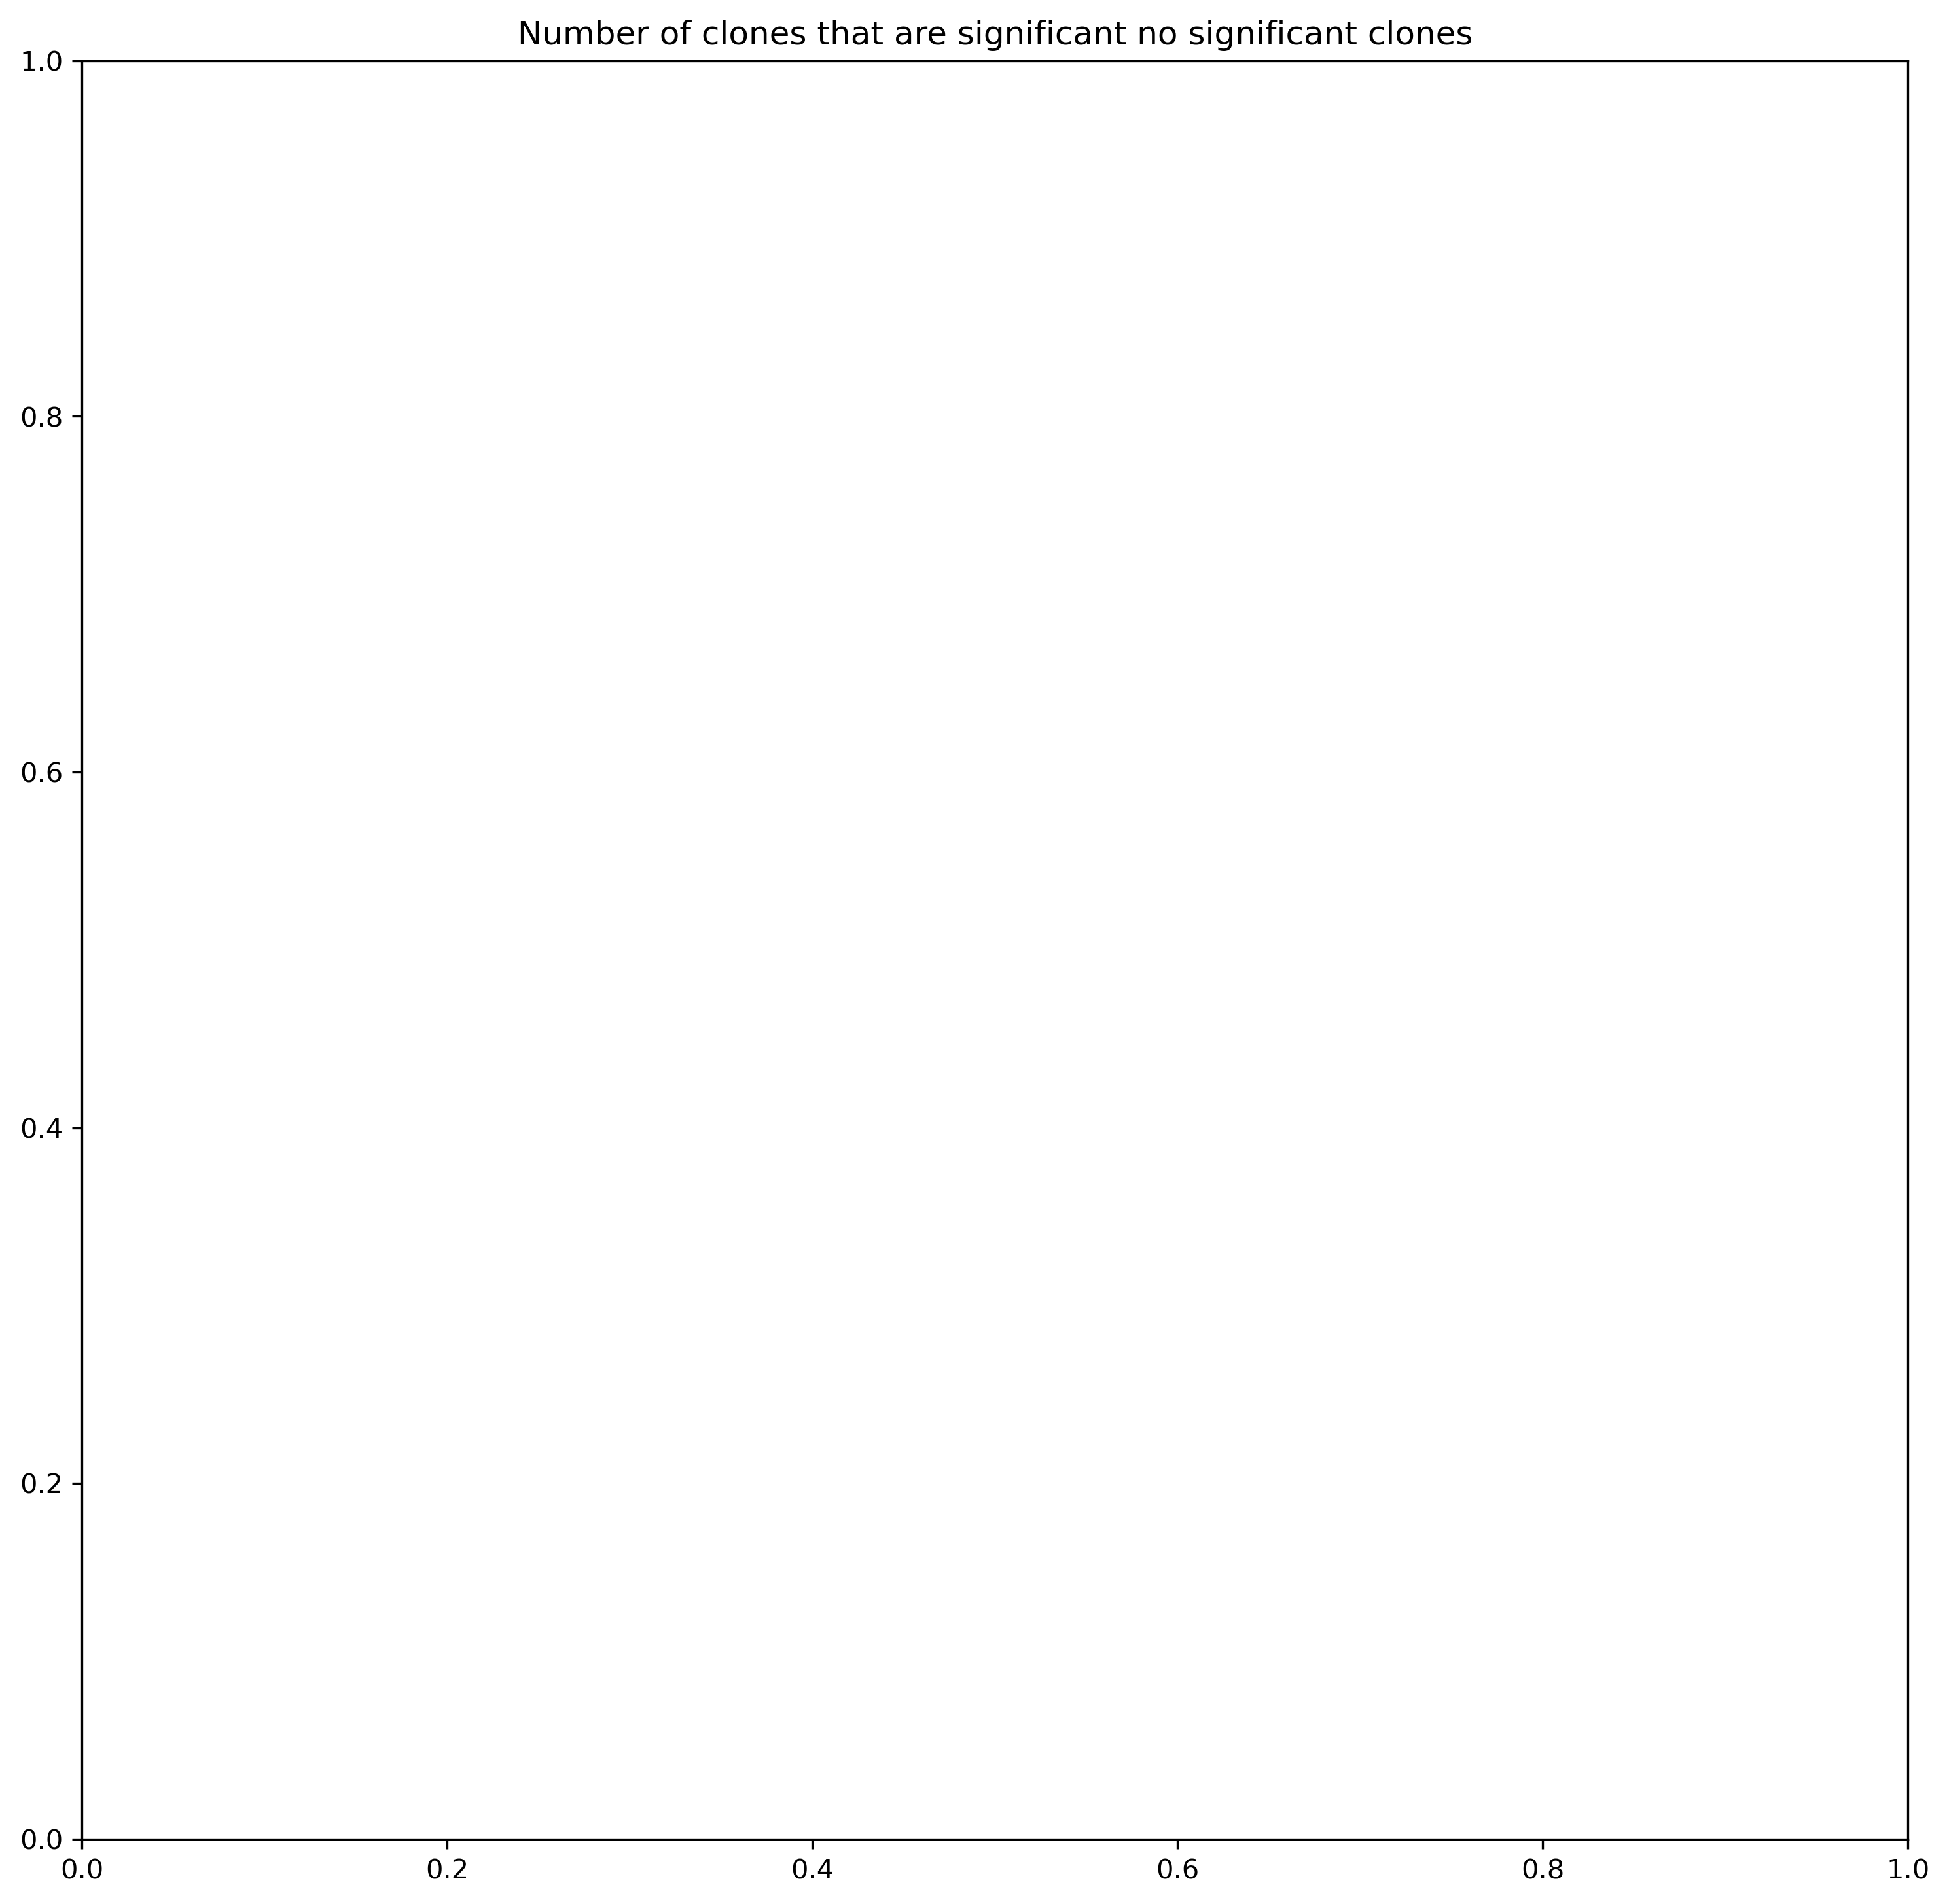

In [14]:
a_input = df.loc[(df["method"] == "hypergeo") & (df["condition"] == "input")].pivot(index="index", columns="variable", values="pval")
b_cultured = df.loc[(df["method"] == "hypergeo") & (df["condition"] == "cultured")].pivot(index="index", columns="variable", values="pval")
merged_df, merged_count_df = cs.merge_hypergeom(a_input, b_cultured, 
                                             "Input", "Cultured", p_thresh=p_thresh,
                                             f_save=join(outdir, f"culture_input_clone_lineages"))


In [15]:
a_sig = p_df_out[clone_meta[clone_meta["condition"]=="input"].index]
b_sig = p_df_out[clone_meta[clone_meta["condition"]=="cultured"].index]
a_sig.columns = [x.replace("_cultured","").replace("_input","") for x in a_sig.columns]
b_sig.columns = [x.replace("_cultured","").replace("_input","") for x in b_sig.columns]

a_sig    name Input    sig
0   0_0     0  False
1  0_10     0  False
2  0_11     0  False
3  0_12     0  False
4  0_14     0  False
(25, 0)
b_sig Empty DataFrame
Columns: [name, Cultured, sig]
Index: []
merge_df Empty DataFrame
Columns: []
Index: [0, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8]
count Empty DataFrame
Columns: []
Index: [0, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8]
No clones significant
a_sig    name Input    sig
0   0_0     0  False
1  0_10     0  False
2  0_11     0  False
3  0_12     0  False
4  0_14     0  False
(25, 0)
b_sig Empty DataFrame
Columns: [name, Cultured, sig]
Index: []
merge_df Empty DataFrame
Columns: []
Index: [0, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8]
count Empty DataFrame
Columns: []
Index: [0, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8]
No clones significant
a_sig    name Input    sig
0   0_0     0  False
1  0_10     0  False
2  0_11     0  False
3  0_12     0  False
4  0_14     0  False
(25, 0)
b_sig Empty DataFrame
Columns: [name, Cultured, sig]
Index: []
merge_df Empty Da

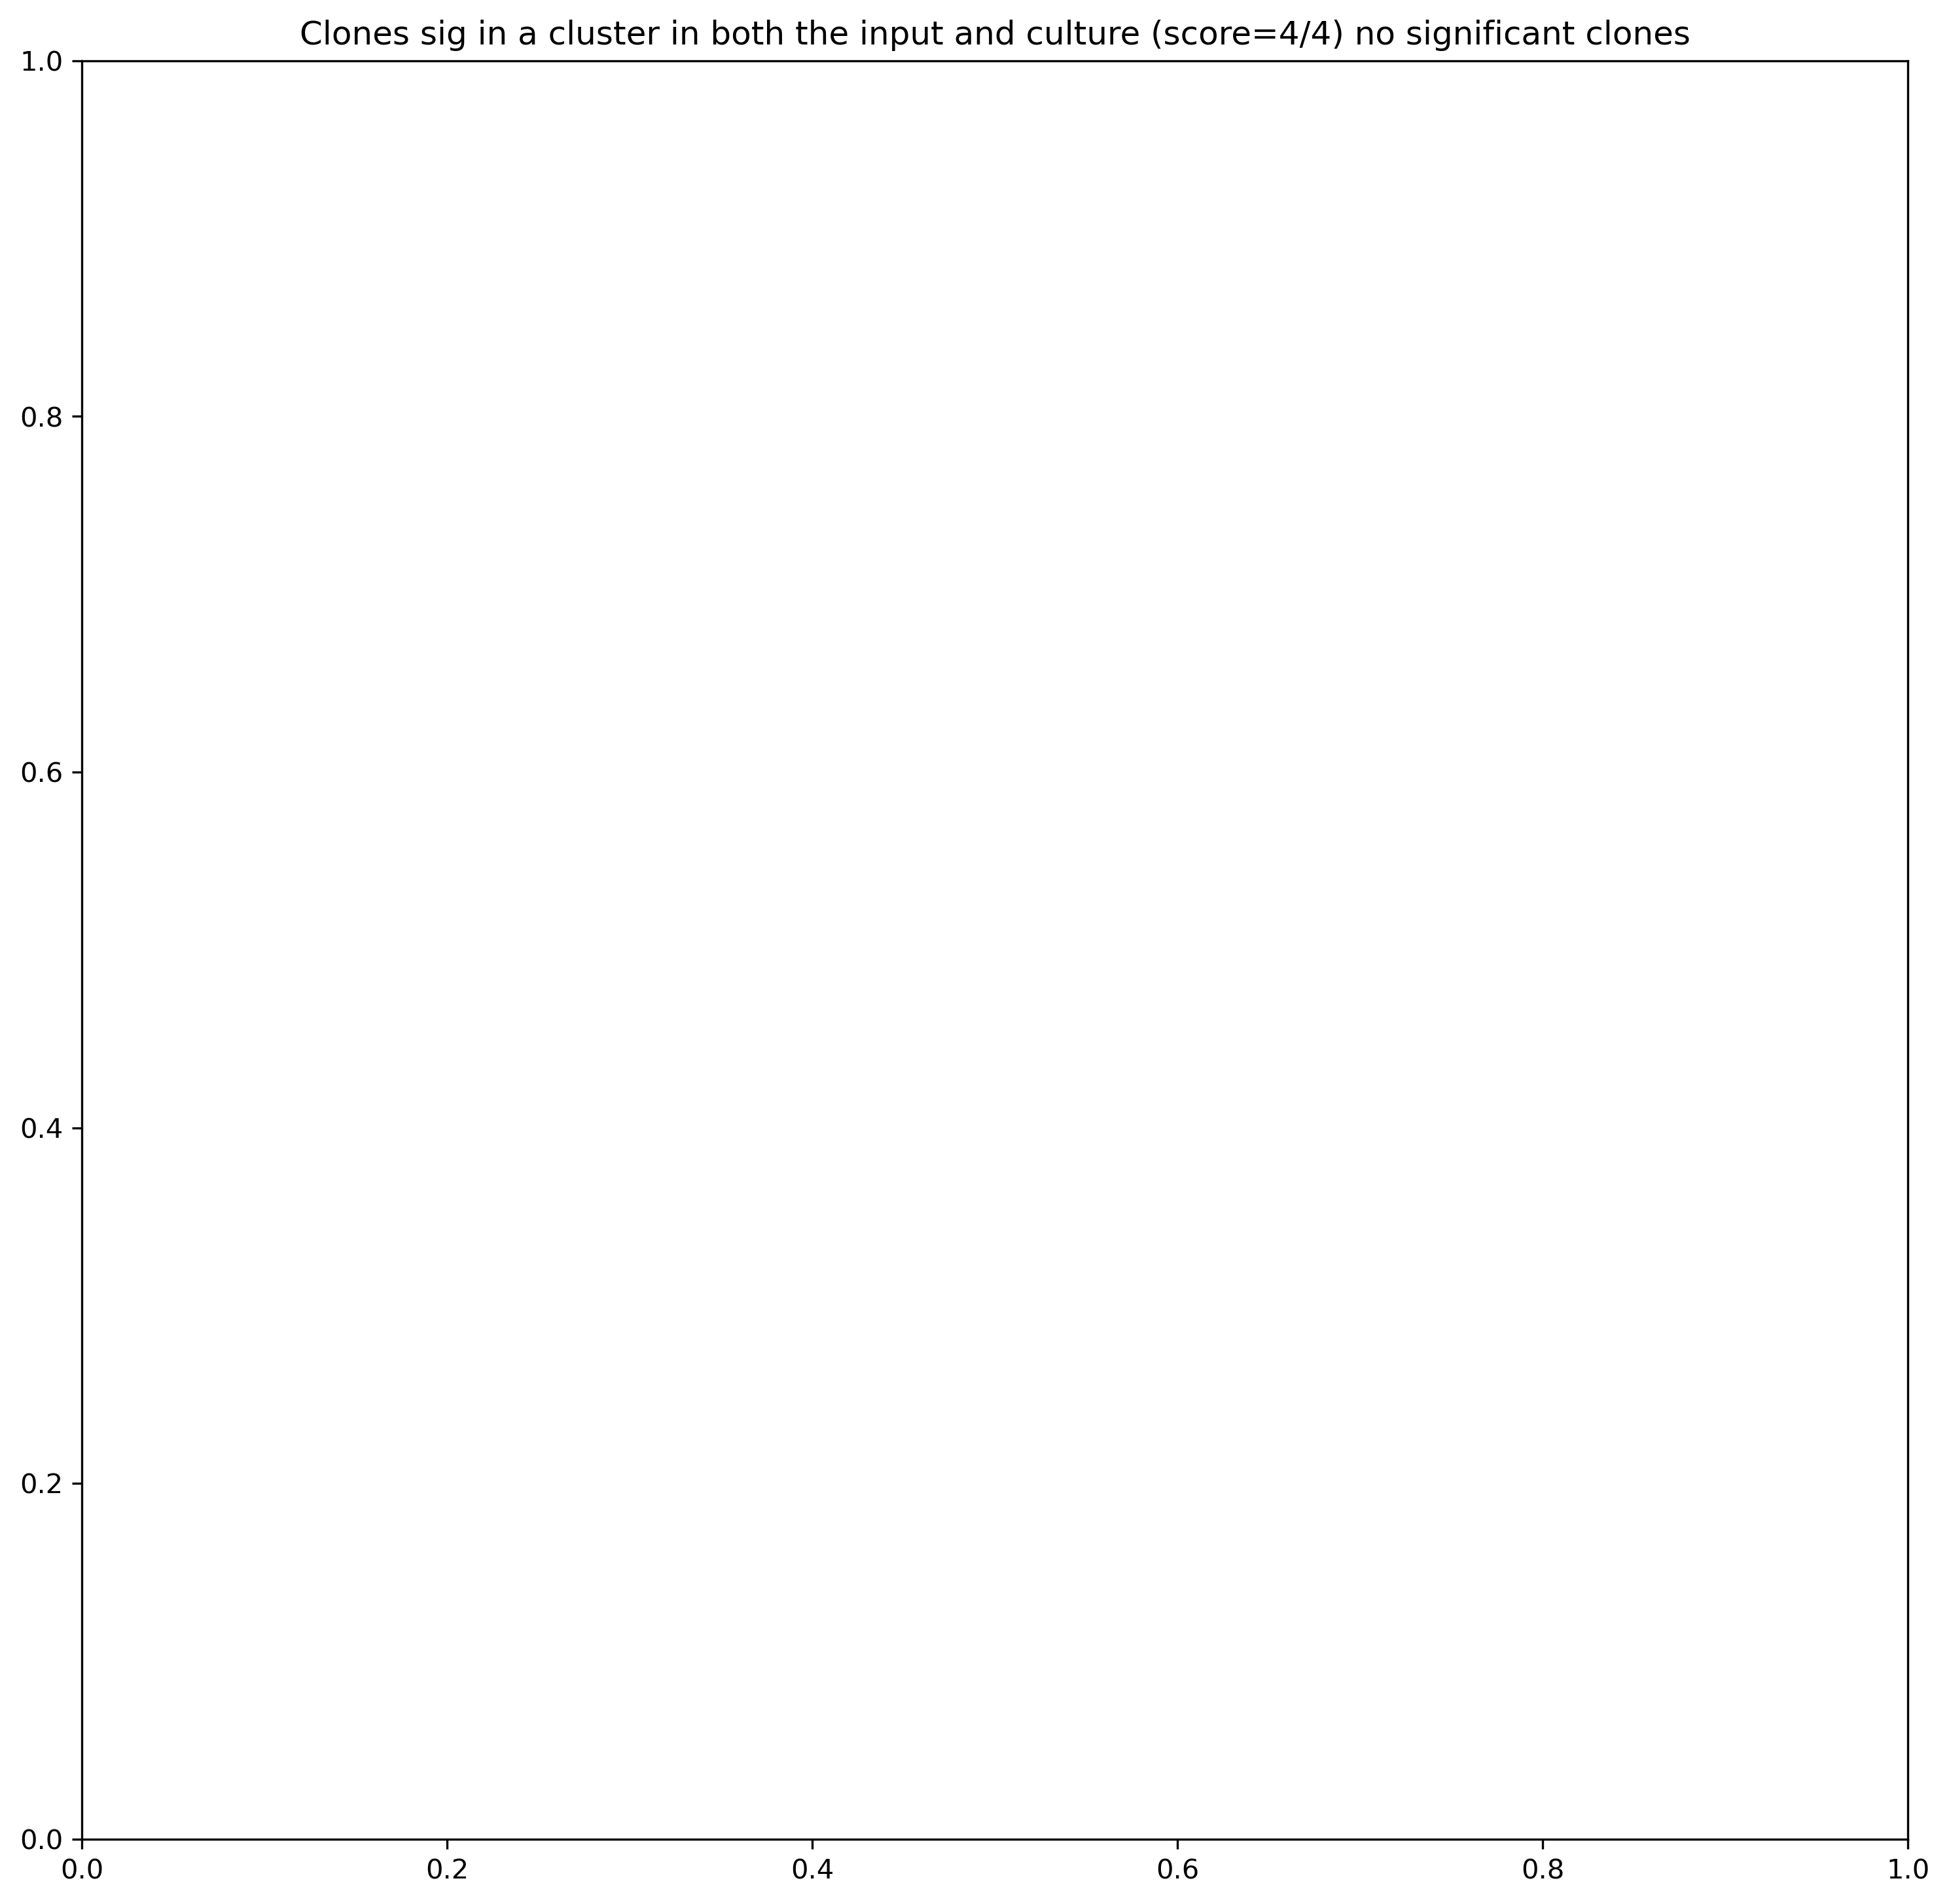

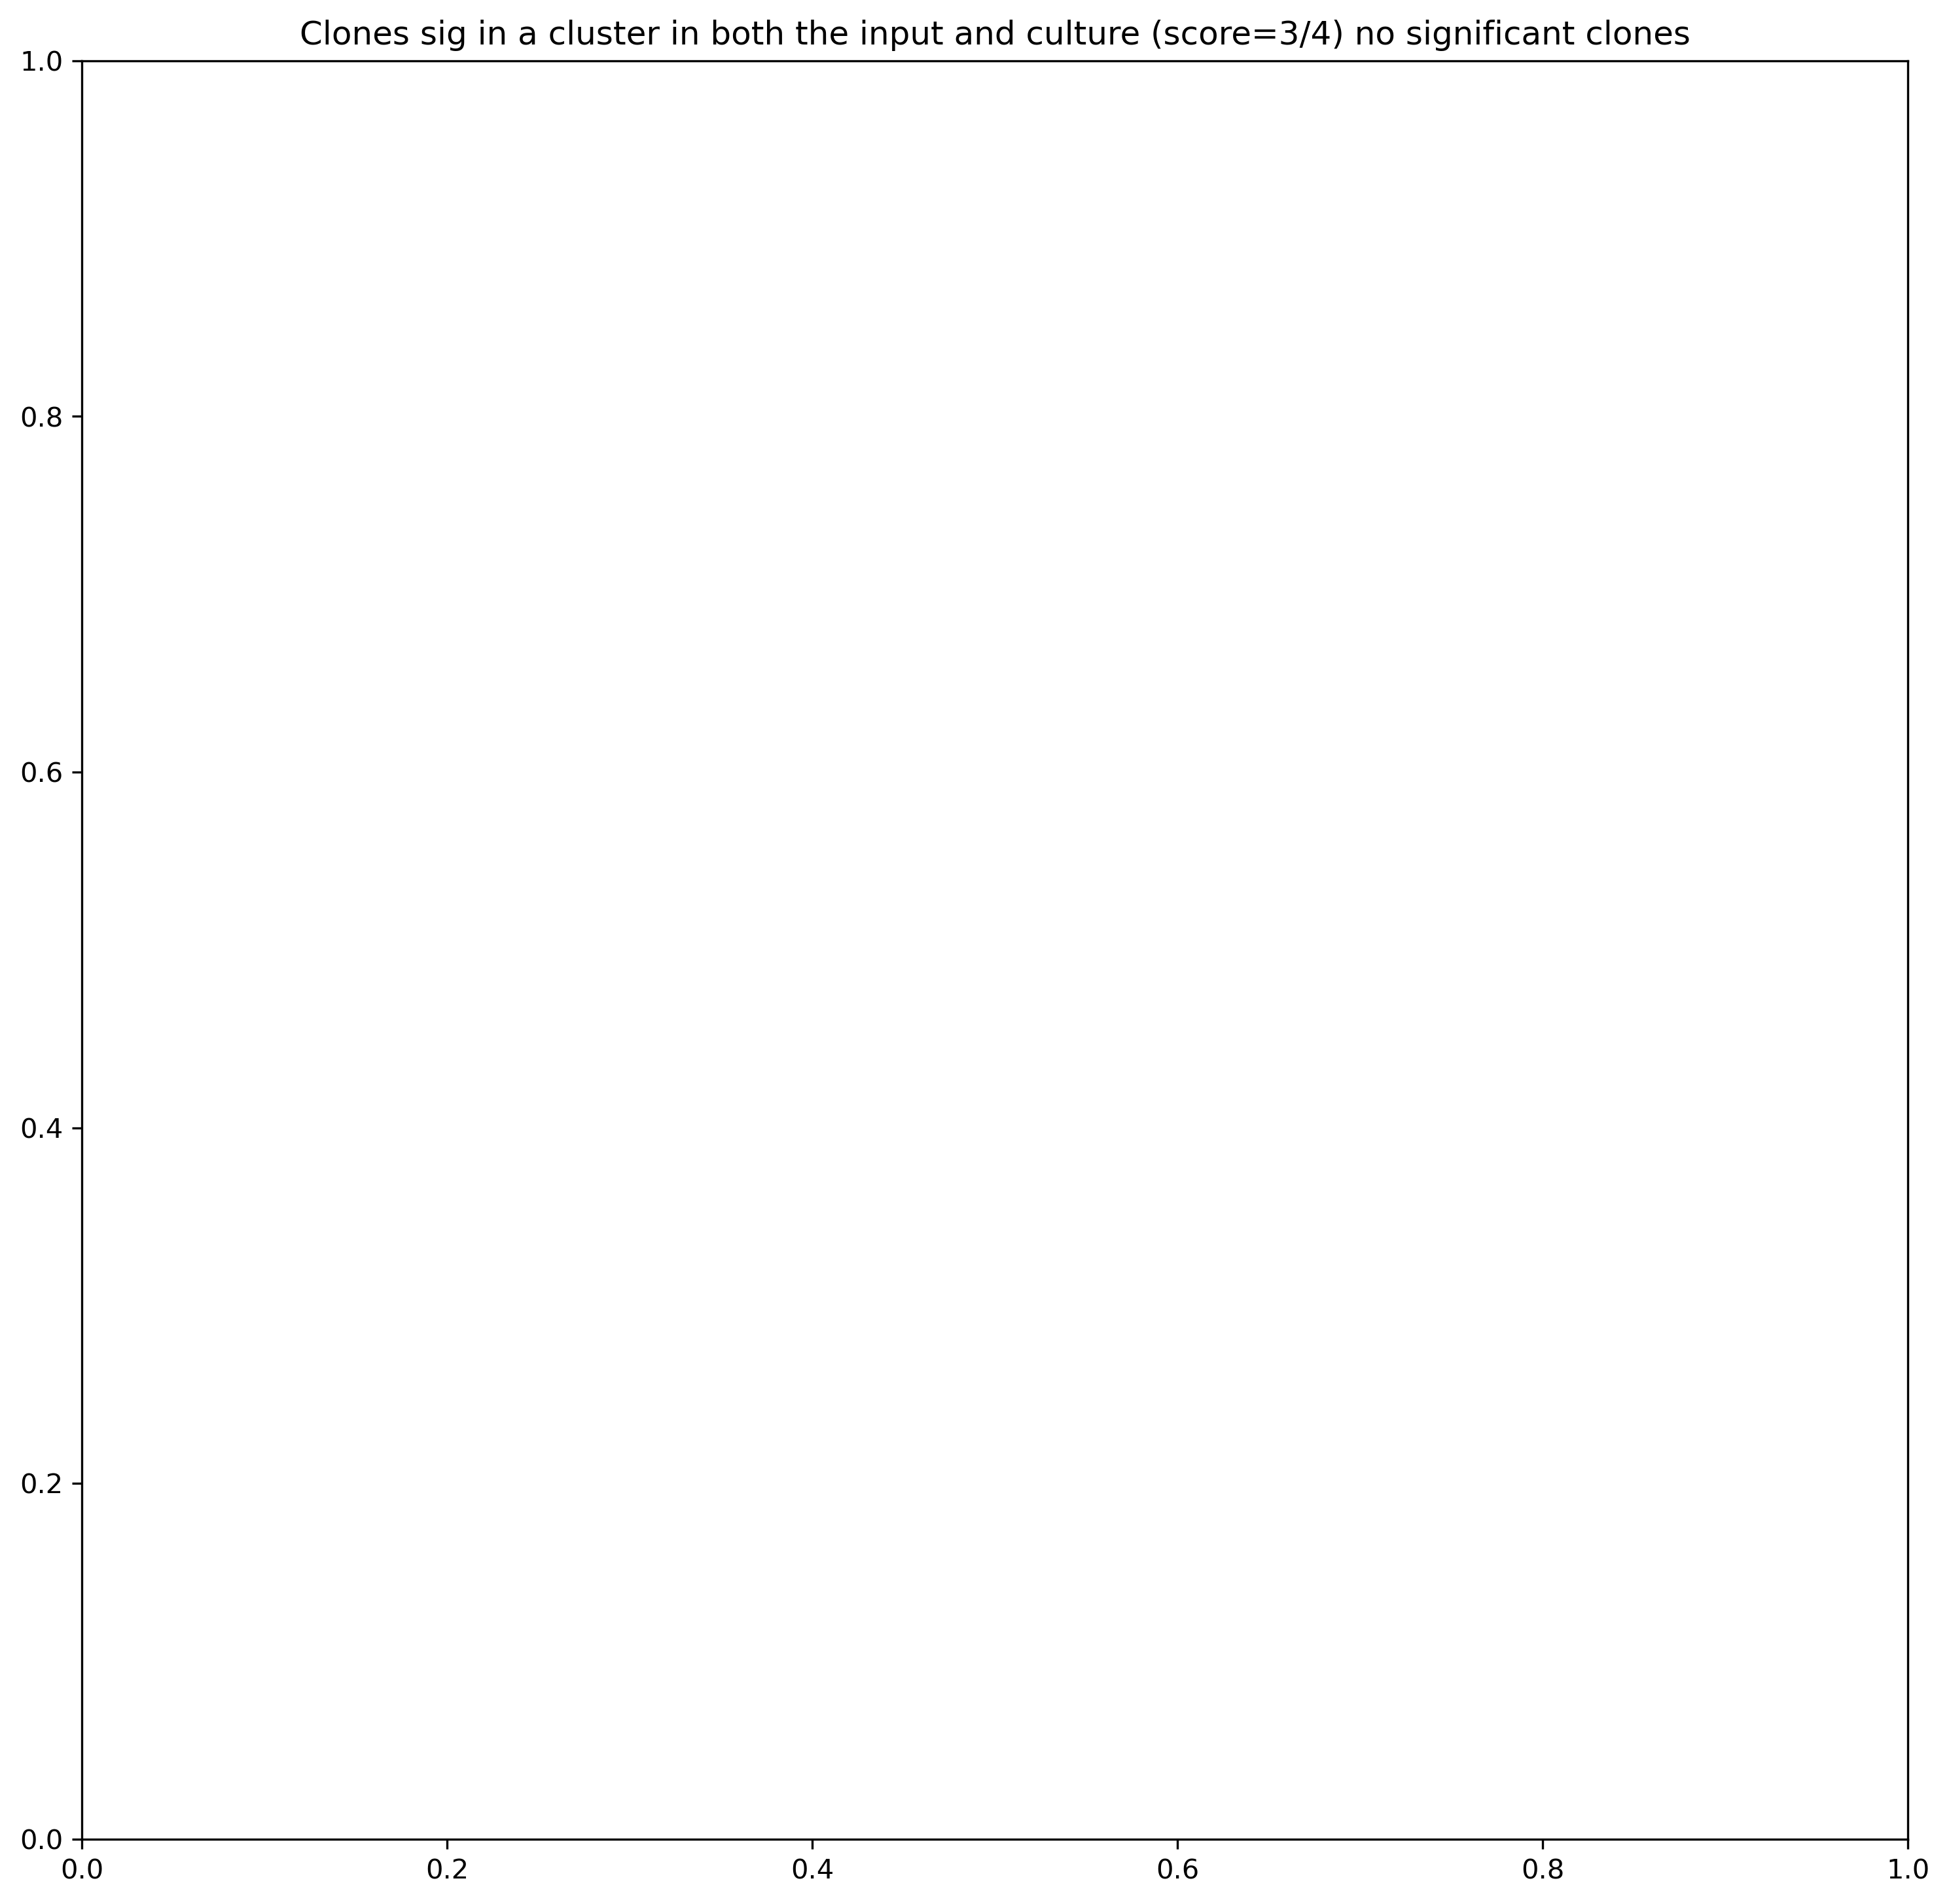

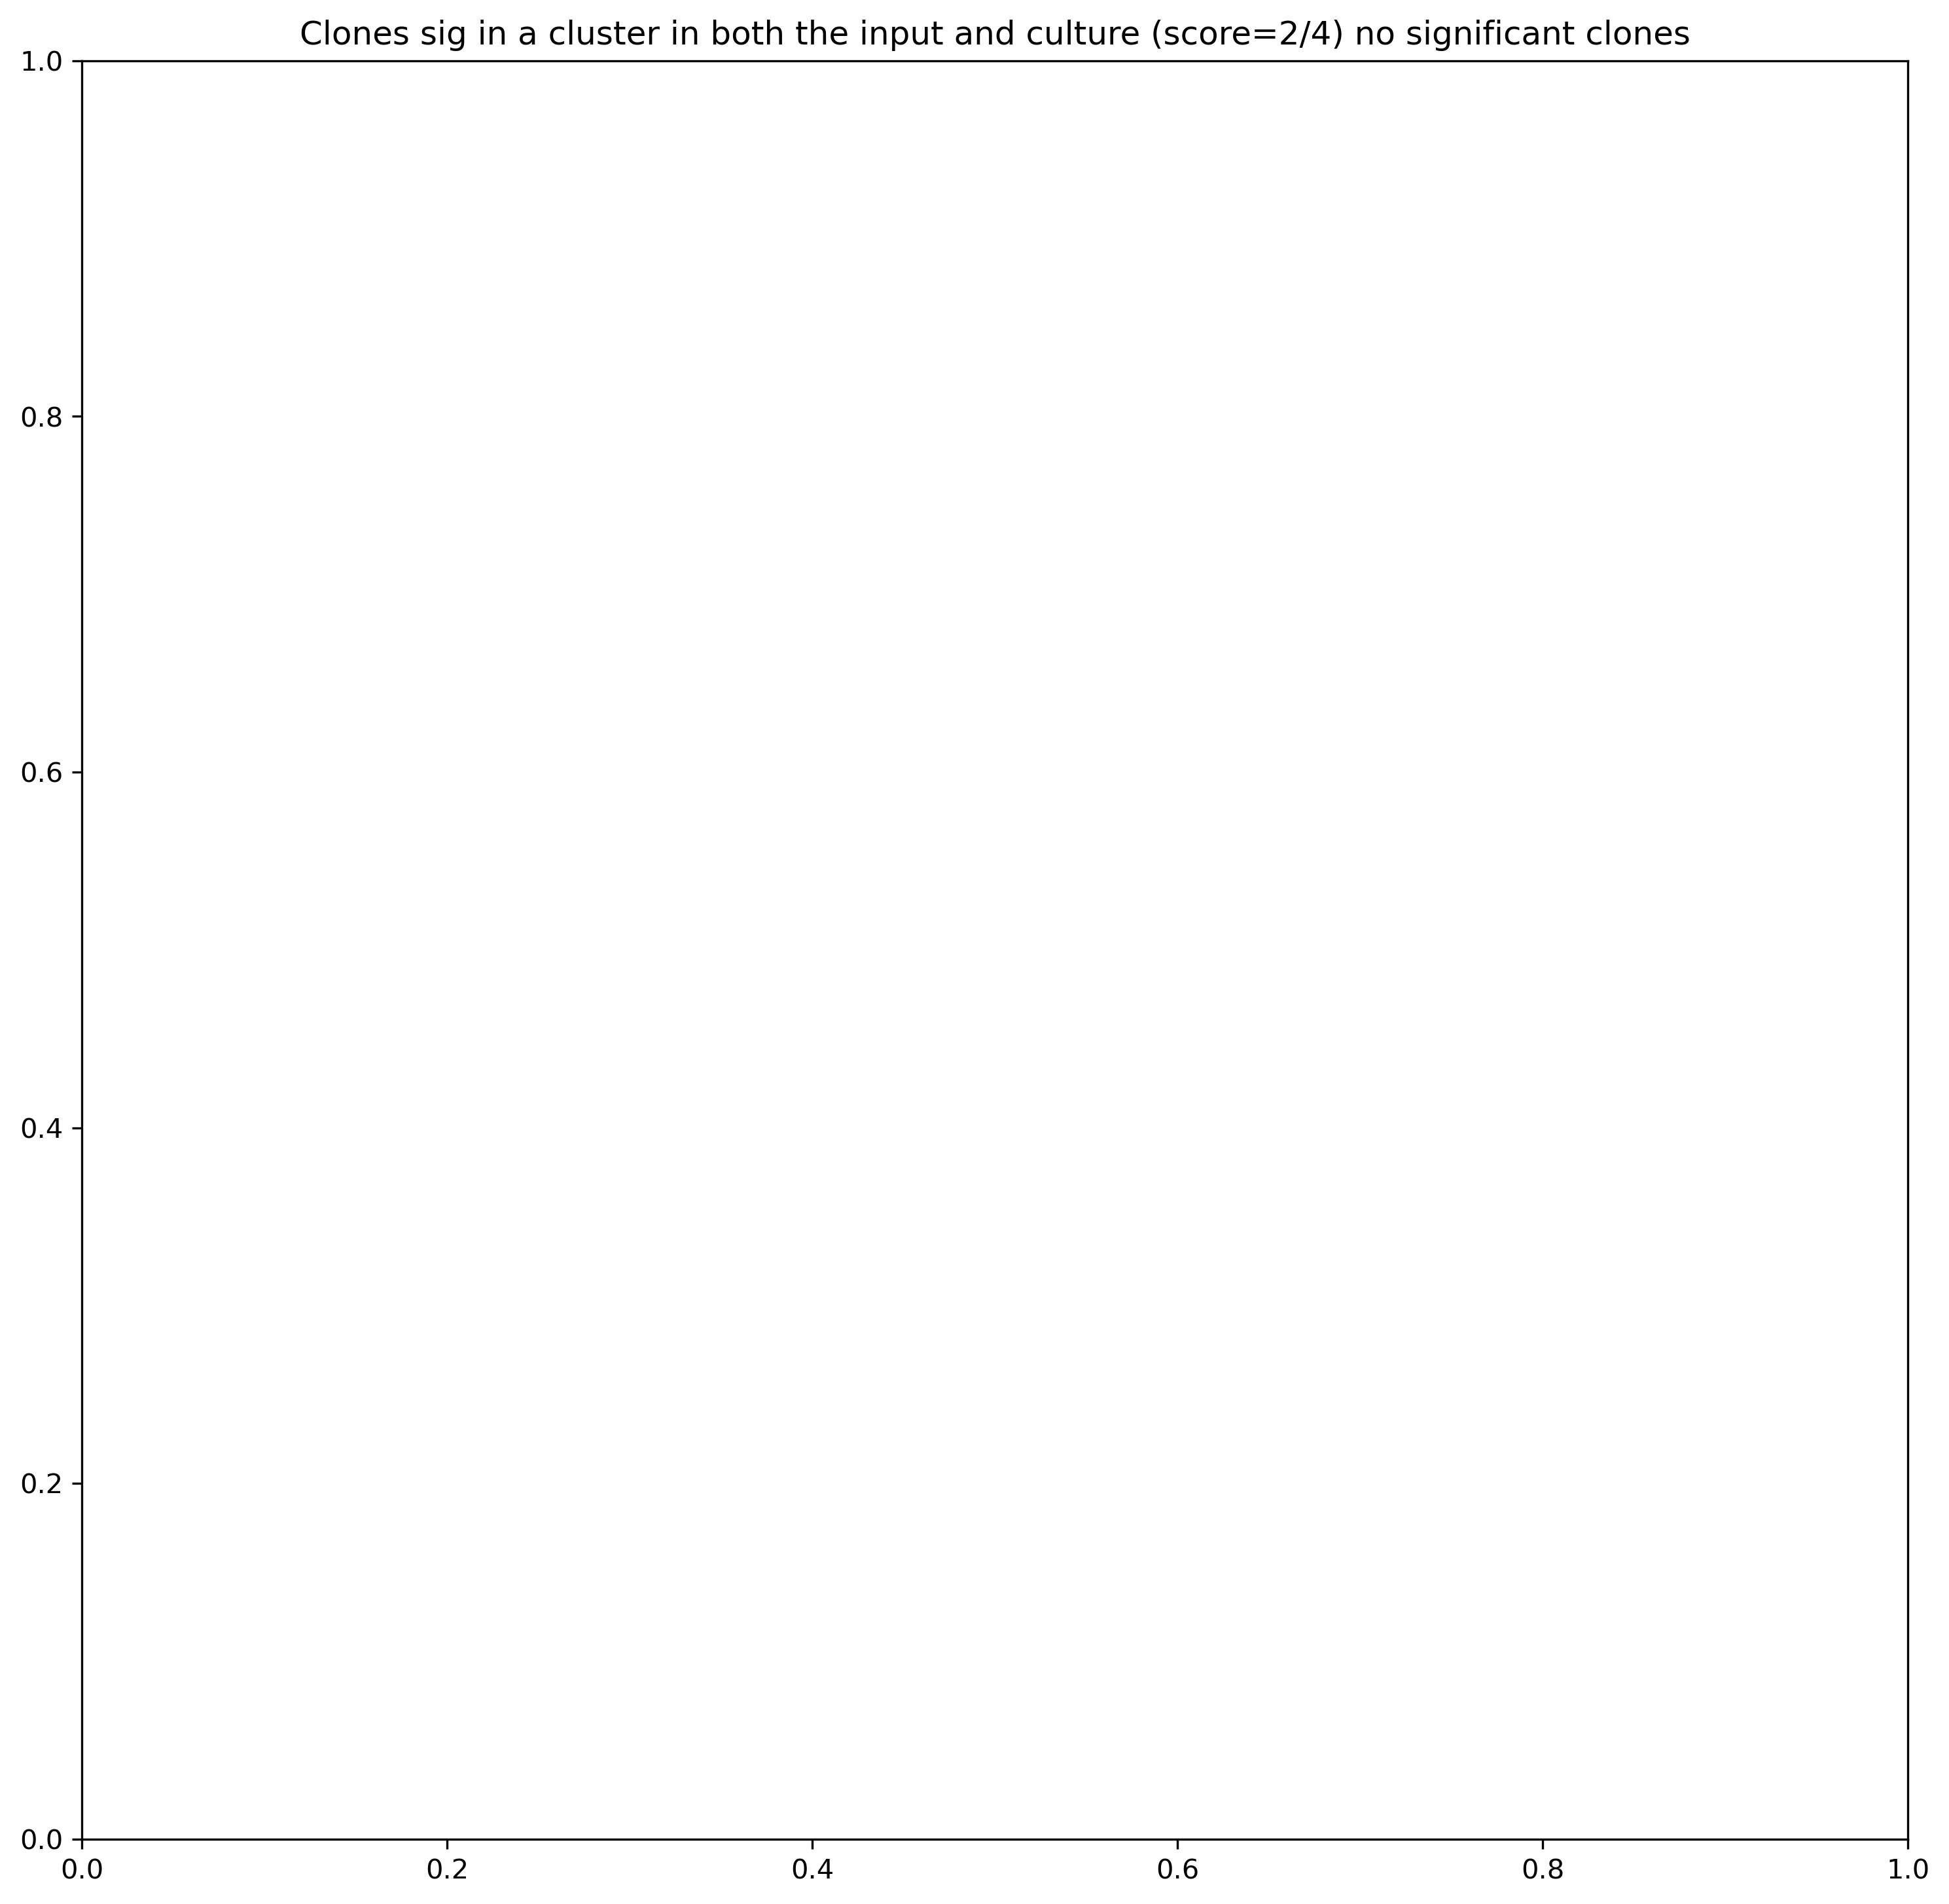

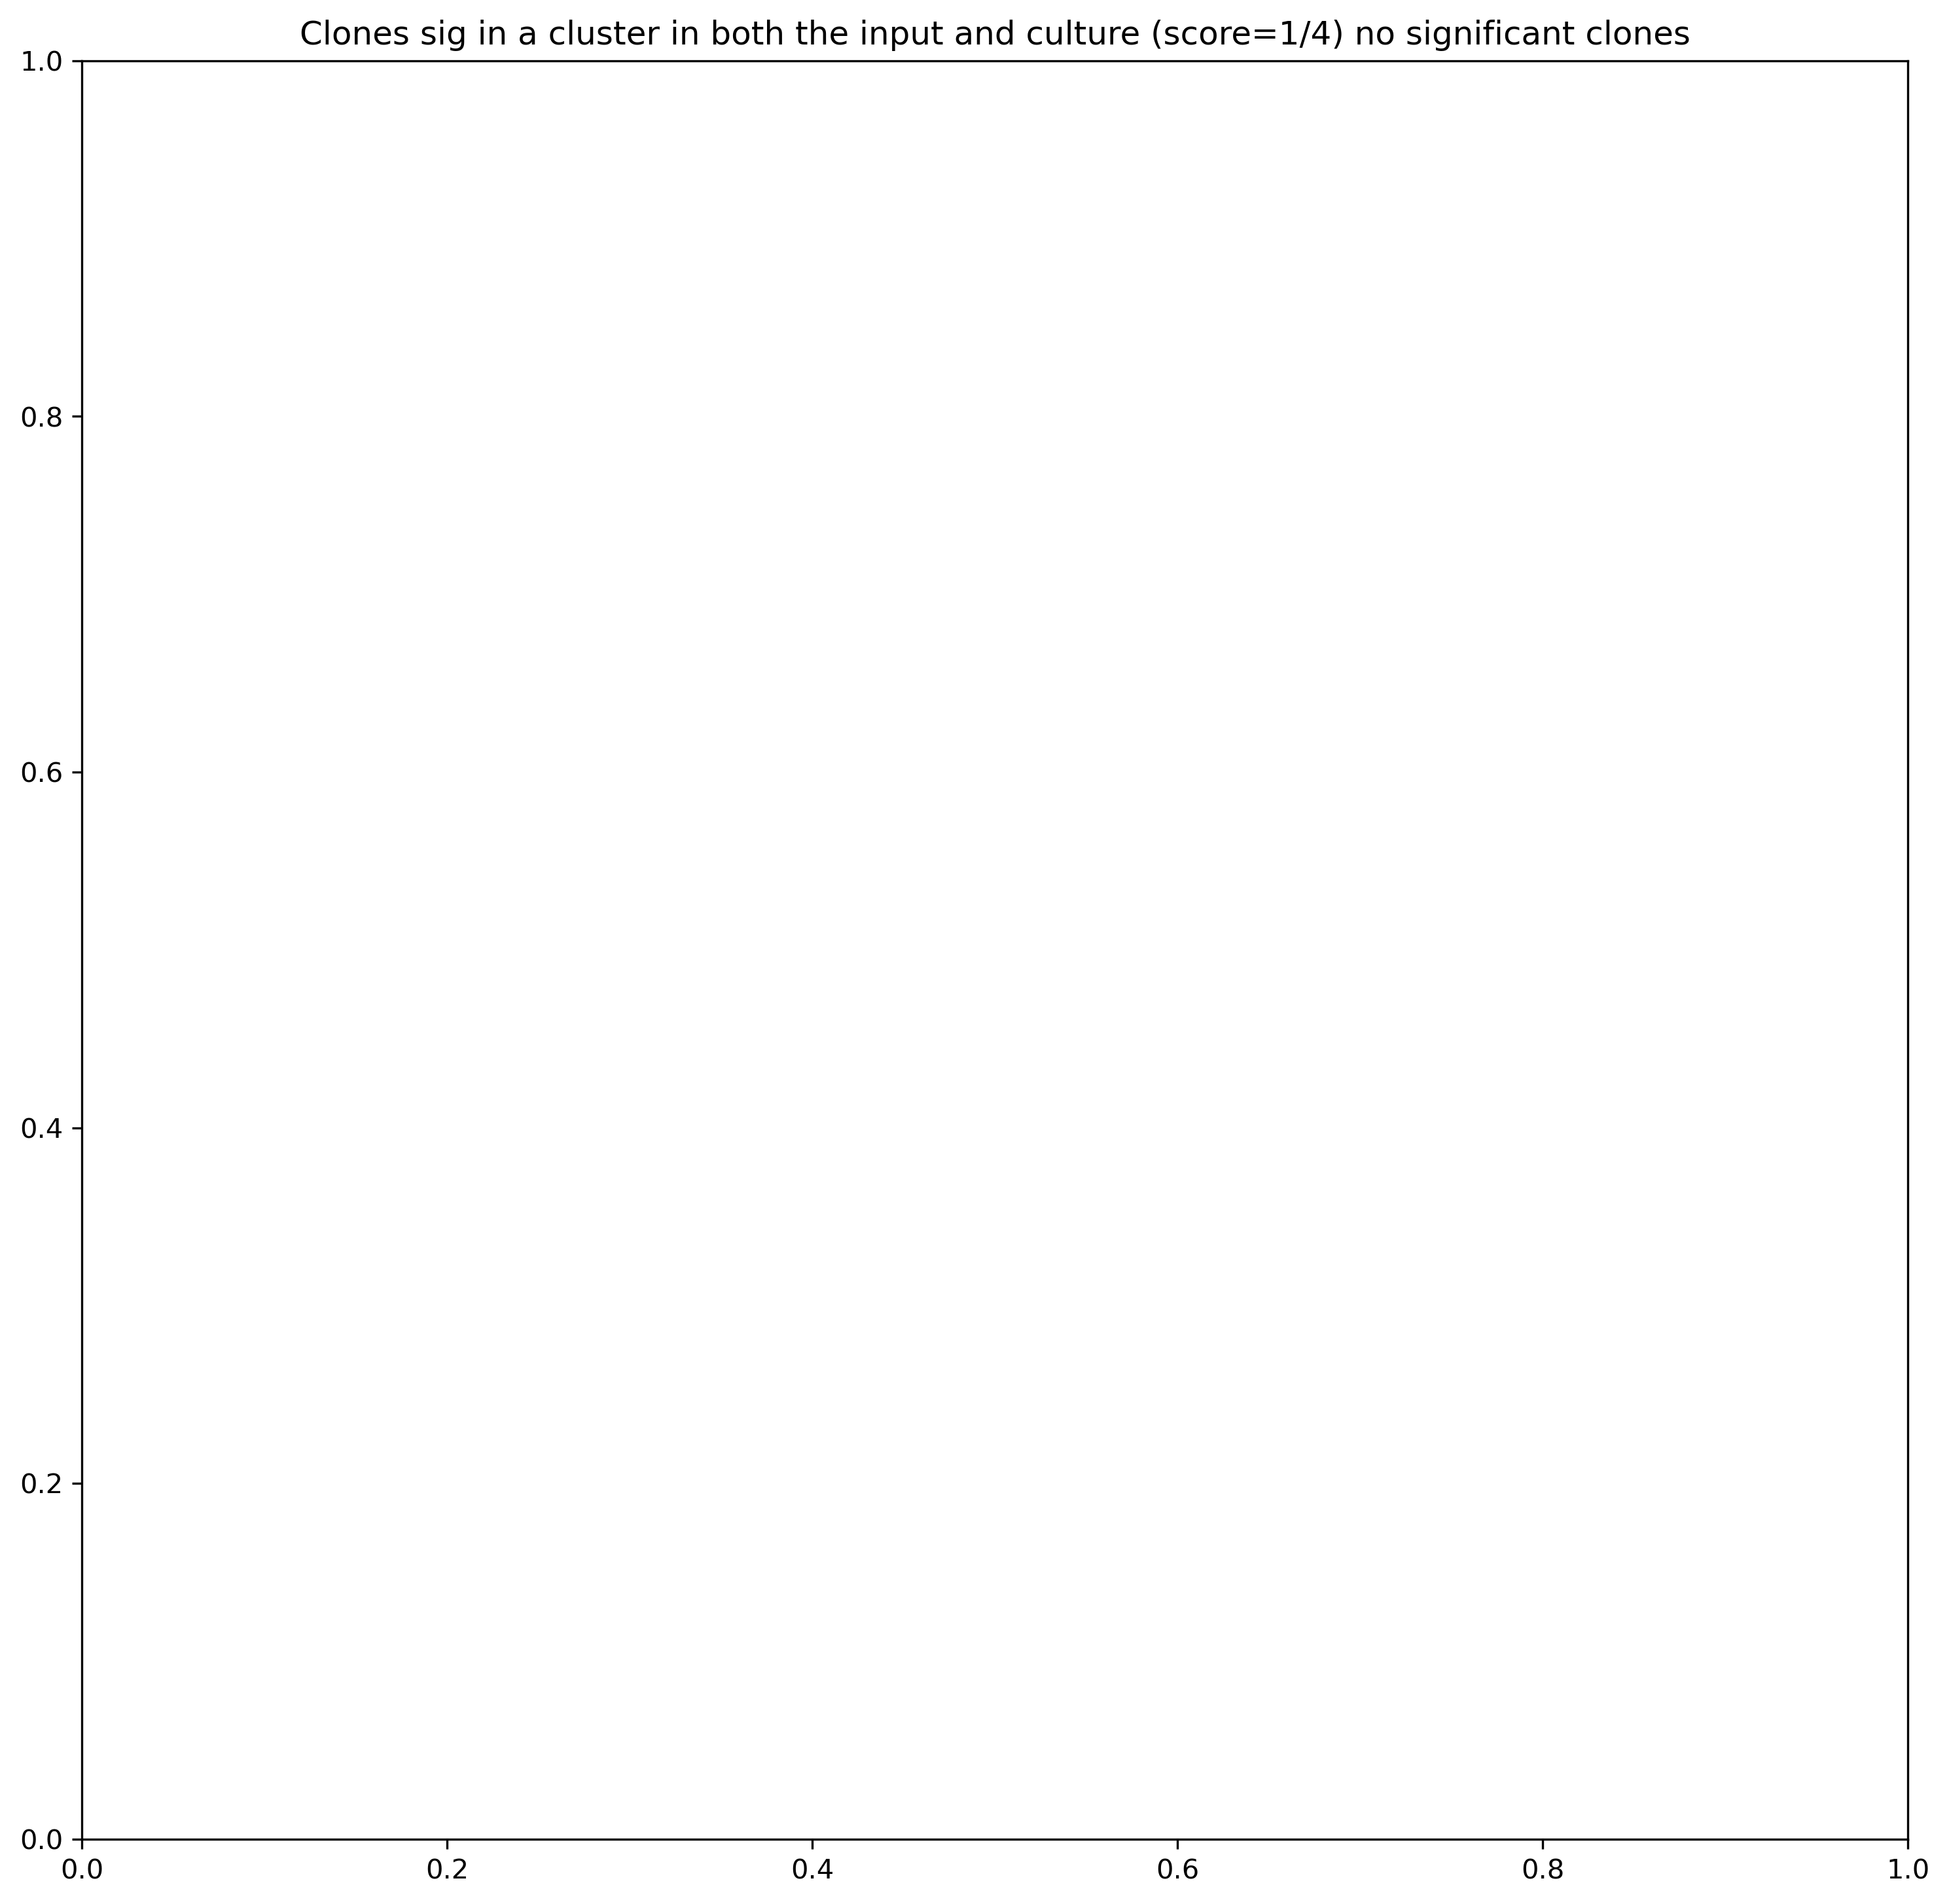

In [16]:
merged_df, merged_count_df = cs.merge_hypergeom(1/(1+a_sig), 1/(1+b_sig), 
                                               "Input", "Cultured", p_thresh=0.25,
                                                title="Clones sig in a cluster in both the input and culture (score=4/4)",
                                                f_save=join(outdir,f"sig_score4_culture_input_clone_lineages"))


merged_df, merged_count_df = cs.merge_hypergeom(1/(1+a_sig), 1/(1+b_sig), 
                                                "Input", "Cultured", p_thresh=0.33,
                                                title="Clones sig in a cluster in both the input and culture (score=3/4)",
                                                f_save=join(outdir,f"sig_score3_culture_input_clone_lineages"))


merged_df, merged_count_df = cs.merge_hypergeom(1/(1+a_sig), 1/(1+b_sig), 
                                             "Input", "Cultured", p_thresh=0.5,
                                             title="Clones sig in a cluster in both the input and culture (score=2/4)",
                                             f_save=join(outdir,f"sig_score2_culture_input_clone_lineages"))


merged_df, merged_count_df = cs.merge_hypergeom(1/(1+a_sig), 1/(1+b_sig), 
                                             "Input", "Cultured", p_thresh=1,
                                             title="Clones sig in a cluster in both the input and culture (score=1/4)",
                                             f_save=join(outdir,f"sig_score1_culture_input_clone_lineages"))


## Get the minimum of each clone shift. This will be used for rankigng later

In [17]:
p_df_sep = p_df_group.reset_index().groupby(["index", "condition"]).sum().reset_index()
p_df_sep

,index,condition,0
0,0_0,input,9
1,0_10,input,4
2,0_11,input,2
3,0_12,input,2
4,0_14,input,4
5,0_15,input,2
6,0_18,input,3
7,0_19,input,3
8,0_20,input,3
9,0_21,input,4


In [18]:
def sum_hyper_score(ser):
    out = {}
    tot = 0
    for ind, val in p_df_sep[p_df_sep["index"]==ser.name].iterrows():
        out[f'hyper_score_{val["condition"]}'] = val[0]
        tot += val[0]
    out["hyper_score"] = tot
    return out



min_df = df.groupby(["index", "method", "condition"]).min()["pval"].reset_index().sort_values("pval")
min_df

min_df_wide = min_df.pivot(index="index", values="pval", columns=["method", "condition"])
min_df_wide.columns = ['_'.join(col).strip() for col in min_df_wide.columns.values] # flatten to 1D columns
min_df_wide
ncells_df["ncells"] = ncells_df.sum(axis=1)
min_df_wide = pd.concat((ncells_df, norm_ncells_df[["fold"]], min_df_wide), axis=1)
# min_df_wide = pd.merge(min_df_wide, norm_ncells_df, left_index=True, right_index=True, 
#                       suffixes=("", "_norm"))


if is_mt:
    print("removing donor specific variants")
    print(min_df_wide.shape)
    clone_order_keep = []
    cells_meta = pd.read_csv(cells_meta_f, sep="\t", index_col=0)
    kept_clones = []
    kept_clones_cells = []
    
    for x in cells_meta.columns:
        if "cloneID_" in x:
            kept_clones_cells.append(x)
            kept_clones.append(x.replace("cloneID_", ""))
    
    min_df_wide = min_df_wide.loc[min_df_wide.index.isin(kept_clones)]
    print("after removal")
    print(min_df_wide.shape)

min_df_wide = min_df_wide.fillna(0)
min_df_wide = min_df_wide.sort_values("ncells", ascending=False)

min_df_wide = pd.concat((min_df_wide.apply(sum_hyper_score, result_type='expand', axis=1), min_df_wide ), axis=1)
min_df_wide

frst_cols = ["ncells", "hyper_score", "fold"]
min_df_wide = min_df_wide[frst_cols + [i for i in min_df_wide.columns.values if i not in frst_cols]]
min_df_wide

,ncells,hyper_score,fold,hyper_score_input,count_input,count_cultured,clone_all_input,clone_min_input,global_all_input,global_min_input,hypergeo_input
0_0,157,9,0.0,9,157,0,0.0,0.0,0.0,0.0,0.003796
0_4,38,0,0.0,0,38,0,1.0,1.0,1.0,1.0,0.118465
0_5,32,0,0.0,0,32,0,1.0,1.0,1.0,1.0,0.186663
0_6,26,2,0.0,2,26,0,1.0,1.0,1.0,1.0,0.073368
0_8,13,0,0.0,0,13,0,1.0,1.0,1.0,1.0,0.121814
0_11,8,2,0.0,2,8,0,1.0,1.0,1.0,1.0,0.094473
0_10,6,4,0.0,4,6,0,1.0,1.0,1.0,1.0,0.073368
0_12,6,2,0.0,2,6,0,1.0,1.0,1.0,1.0,0.077200
0_21,6,4,0.0,4,6,0,1.0,1.0,1.0,1.0,0.073368
0_9,6,4,0.0,4,6,0,1.0,1.0,1.0,1.0,0.003796


# *Get the representative clones:
a. top 3 by size  
b. bottom 2 by size (min 10)  
c. top 2 by clonal shift score  
d. top 2 and bottom 2 by fold  

Save how they were chosen. 
Put in this order (but if there's duplicates, drop those)




In [19]:
def add_to_ord(k, out_ord):
    if k not in out_ord:
        out_ord.append(k)
    return out_ord

def rep_clones(df):
    out_cl = {}
    out_ord = []
    
    # ncells
    
    ## top ncells
    ncells = df['ncells'].sort_values()[::-1]
    
    
    out_cl[("ncells", 1) ] = ncells.index[0]
    out_ord.append(ncells.index[0])
    
    out_cl[("ncells", 2)] = ncells.index[1]
    add_to_ord(ncells.index[1], out_ord)
    
    ## bottom ncells
    ncells = ncells[ncells>10]
    #if ncells
    if len(ncells.shape) > 2: #more than just top 2
        out_cl[("smallest_ncells", 1)] = ncells.index[-1]
        add_to_ord(ncells.index[-1], out_ord)
        if len(ncells.shape) > 3:
            out_cl[("smallest_ncells", 2)] = ncells.index[-2]
            add_to_ord(ncells.index[-2], out_ord)
    
    # hyper score
    hyper_score = df['hyper_score'].sort_values()[::-1]
    hyper_score = hyper_score[hyper_score>0]
    for i in range(min(2, len(hyper_score))):
        out_cl[("hyper", i+1)] = hyper_score.index[i]
        add_to_ord(hyper_score.index[i], out_ord)
        
    # fold in culture
    fold = df['fold'].sort_values()[::-1]
    out_cl[("culture_fold", 1) ] = fold.index[0]
    add_to_ord(fold.index[0], out_ord)
    out_cl[("culture_fold", 2)] = fold.index[1]
    add_to_ord(fold.index[1], out_ord)
    
    return out_cl, out_ord

clone_reps, clone_rep_order = rep_clones(min_df_wide)
print(clone_rep_order)
clone_reps


['0_0', '0_4', '0_29', '0_24', '0_15']


{('ncells', 1): '0_0',
 ('ncells', 2): '0_4',
 ('hyper', 1): '0_0',
 ('hyper', 2): '0_29',
 ('culture_fold', 1): '0_24',
 ('culture_fold', 2): '0_15'}

## Save

In [20]:
with open(join(outdir, "representative_cloneID.txt"), 'w') as f:
    f.write('\n'.join(clone_rep_order))

pd.Series(clone_reps).reset_index().to_csv(join(outdir, "representative_cloneID.csv"), header=None, 
                                           index=False)

